In [ ]:
from google.colab import files
files.upload()

In [2]:
!mkdir ~/.kaggle/

In [3]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c dogs-vs-cats

 98% 793M/812M [00:07<00:00, 211MB/s]
100% 812M/812M [00:08<00:00, 106MB/s]


In [5]:
!unzip -qq dogs-vs-cats.zip

In [6]:
!unzip -qq train.zip

The code arranges a cat and dog pictures dataset into subdirectories for training, validation, and testing, copying a specified number of images in each subdirectory from the main folder.

In [7]:
import os, shutil, pathlib

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_1")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)

make_subset("train", start_index=0, end_index=1000)
make_subset("validation", start_index=1000, end_index=1500)
make_subset("test", start_index=1500, end_index=2000)

This code is a Keras model with a TensorFlow backend which creates the datasets based on the directories having images for training, validation, and testing. Each dataset has images resized to 180x180 pixels and batched into groups of 32.

In [8]:
from tensorflow.keras.utils import image_dataset_from_directory

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


These piece of the code creates a dataset with 1000 samples consisting of 16 random normal distributions. Then, it iterates through the dataset to print the shape of each element. It stops printing the shape after three elements.

In [9]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


This code manages to batch a dataset that contains 32 samples a batch. Output. Then, it starts with printing the shape of the first three batches, after that stopping.

In [10]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


This code includes a mapping to transform every element in the dataset into a 4x4 matrix and then move over the transformed dataset, which allows printing of the shape of the first three elements.

In [11]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


The code here will loop through the batches of the training data along with its own labels for printing the shape of every batch of data and labels. Subsequently, it will break out of the loop.

In [12]:
for data_batch, labels_batch in train_dataset:
    print("data batch shape:", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape: (32, 180, 180, 3)
labels batch shape: (32,)


This code initializes a CNN model with multiple convolution and pooling layers interconnected by dropout layer for the output layer followed by the sigmoid activation function.

In [13]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
a = layers.Rescaling(1./255)(inputs)
a = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(a)
a = layers.MaxPooling2D(pool_size=2)(a)
a = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(a)
a = layers.Flatten()(a)
a = layers.Dropout(0.5)(a)
outputs = layers.Dense(1, activation="sigmoid")(a)
model = keras.Model(inputs=inputs, outputs=outputs)

Here the code that establishes model for learning defines binary crossentropy as the loss function, Adam as the optimizer, and accuracy as the metric of model evaluation.

In [14]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [15]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 89, 89, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                        

This code uses 50 epochs for training the neural network with the training dataset. It further validates the model on the validation dataset and keeps the best performing model which has the lowest validation loss using the ModelCheckpoint.

In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 20s 151ms/step - loss: 0.7016 - accuracy: 0.4940 - val_loss: 0.6931 - val_accuracy: 0.5050
Epoch 2/50
63/63 [==============================] - 4s 60ms/step - loss: 0.6935 - accuracy: 0.4995 - val_loss: 0.6908 - val_accuracy: 0.5570
Epoch 3/50
63/63 [==============================] - 5s 71ms/step - loss: 0.6906 - accuracy: 0.5450 - val_loss: 0.6846 - val_accuracy: 0.5240
Epoch 4/50
63/63 [==============================] - 6s 94ms/step - loss: 0.6889 - accuracy: 0.5215 - val_loss: 0.6905 - val_accuracy: 0.5200
Epoch 5/50
63/63 [==============================] - 4s 59ms/step - loss: 0.6874 - accuracy: 0.5320 - val_loss: 0.6808 - val_accuracy: 0.5580
Epoch 6/50
63/63 [==============================] - 6s 92ms/step - loss: 0.6790 - accuracy: 0.5770 - val_loss: 0.6867 - val_accuracy: 0.5210
Epoch 7/50
63/63 [==============================] - 4s 60ms/step - loss: 0.6807 - accuracy: 0.5770 - val_loss: 0.6746 - val_accuracy: 0.5790
Epoch 8/50


Using the below code, the graph has been formed as shown in the figures below.

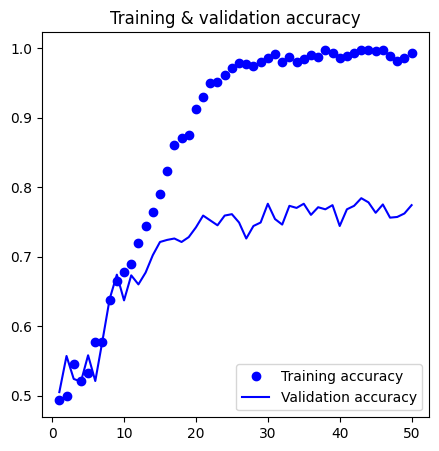

<Figure size 640x480 with 0 Axes>

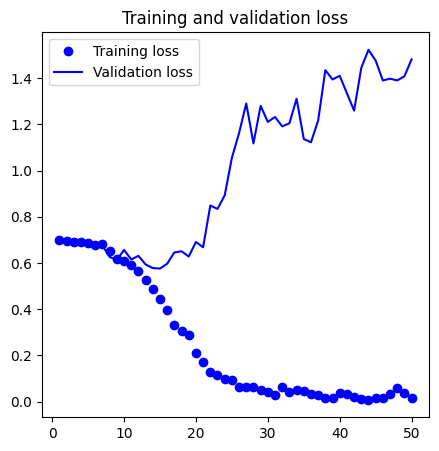

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training & validation accuracy")
plt.legend()
plt.figure()
plt.figure(figsize=(5, 5))
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In this code description, we load the saved model from the "convnet_from_scratch.keras" file, evaluate its performance on the test dataset, and display the test accuracy rounded to three decimal places.

In [18]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 28ms/step - loss: 0.6068 - accuracy: 0.7200
Test accuracy: 0.720


In this code, the loaded model file name is "convnet_from_scratch.keras" and the test accuracy is printed in the three decimals.

In [19]:
import os, shutil, pathlib

shutil.rmtree("./cats_vs_dogs_small_Q2", ignore_errors=True)

original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q2")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 1500 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=2000, end_index=3500)
make_subset("validation", start_index=3501, end_index=4001)
make_subset("test", start_index=4002, end_index=4502)

This objective provides a sequential data augmentation pipeline for image data starting with random horizontal flipping, random rotation less than 0.1 radians, and random zooming up to 0.2 times the original image.

In [20]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

Those codes allow visualization of augmented images by using data augmentation techniques such as flipping, rotation, and zooming to the batch of training images and then displaying nine augmented images on a grid that lack axis labels.

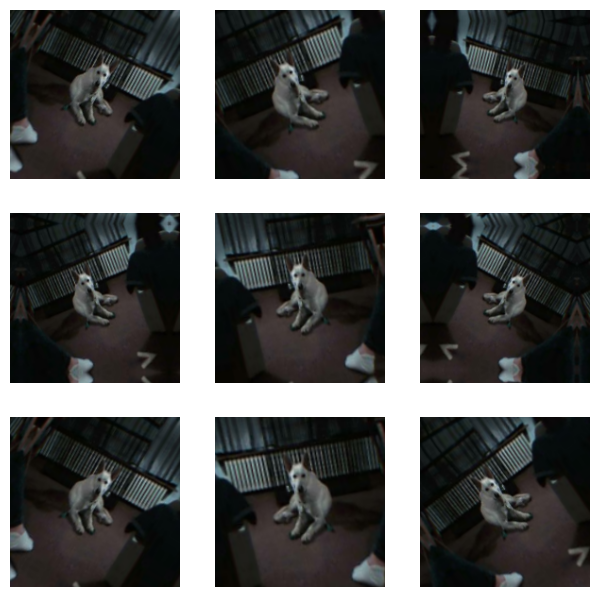

In [21]:
plt.figure(figsize=(7.5,7.5 ))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

This code generates augmented images and displaying them on a grid without axis labels which is achieved through applying the data augmentation techniques like random flipping, rotation and zoom on a set of images from the training dataset.

In [22]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=75,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/75
63/63 [==============================] - 8s 63ms/step - loss: 0.6945 - accuracy: 0.4850 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/75
63/63 [==============================] - 4s 60ms/step - loss: 0.6935 - accuracy: 0.4810 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/75
63/63 [==============================] - 7s 97ms/step - loss: 0.6928 - accuracy: 0.5100 - val_loss: 0.6944 - val_accuracy: 0.5000
Epoch 4/75
63/63 [==============================] - 4s 59ms/step - loss: 0.6942 - accuracy: 0.5115 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 5/75
63/63 [==============================] - 4s 58ms/step - loss: 0.6937 - accuracy: 0.4900 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/75
63/63 [==============================] - 6s 95ms/step - loss: 0.6933 - accuracy: 0.5035 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 7/75
63/63 [==============================] - 4s 62ms/step - loss: 0.6934 - accuracy: 0.5070 - val_loss: 0.6930 - val_accuracy: 0.5000
Epoch 8/75
63

This code plotted the training & validation accuracy within one graph and training & validation loss within another graph, thereby enabling visualization of the model's performance during training.

Such a code fetches the trained model, that got the highest validation performance, evaluates its accuracy on test set and then prints it rounded to three decimal places.

In [24]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 28ms/step - loss: 0.4959 - accuracy: 0.7920
Test accuracy: 0.792


The block of code, here, partitions the dataset in nutshell with the training set made up of 2000 samples and validation and test sets having 500 samples each.

In [25]:
original_dir = pathlib.Path("train")
new_base_dir = pathlib.Path("cats_vs_dogs_small_Q3")

def make_subset(subset_name, start_index, end_index):
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
#Creating training, Test and validation sets.
#Training has 2000 samples, test has 500 samples and validation has 500 samples.
make_subset("train", start_index=4000, end_index=6000)
make_subset("validation", start_index=6001, end_index=6501)
make_subset("test", start_index=6502, end_index=7002)

With data augmentation, multiple convolutional and max-pooling layers, dropout regularization, and a sigmoid output layer, this code describes a convolutional neural network (CNN) model architecture for image classification. The model is then compiled for training using binary crossentropy loss, the Adam optimizer, and an accuracy metric.

In [26]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

With validation, this code trains the specified convolutional neural network model over 75 epochs on the training dataset. It then uses the ModelCheckpoint callback to save the best-performing model based on validation loss.

In [27]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation1.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=75,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/75
63/63 [==============================] - 6s 63ms/step - loss: 0.7002 - accuracy: 0.4935 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/75
63/63 [==============================] - 6s 90ms/step - loss: 0.6932 - accuracy: 0.4970 - val_loss: 0.6891 - val_accuracy: 0.5070
Epoch 3/75
63/63 [==============================] - 5s 75ms/step - loss: 0.6925 - accuracy: 0.5305 - val_loss: 0.6817 - val_accuracy: 0.5810
Epoch 4/75
63/63 [==============================] - 6s 88ms/step - loss: 0.6882 - accuracy: 0.5330 - val_loss: 0.6773 - val_accuracy: 0.6040
Epoch 5/75
63/63 [==============================] - 6s 80ms/step - loss: 0.6857 - accuracy: 0.5430 - val_loss: 0.6741 - val_accuracy: 0.5620
Epoch 6/75
63/63 [==============================] - 4s 59ms/step - loss: 0.6757 - accuracy: 0.5870 - val_loss: 0.6574 - val_accuracy: 0.6250
Epoch 7/75
63/63 [==============================] - 4s 62ms/step - loss: 0.6586 - accuracy: 0.6165 - val_loss: 0.6951 - val_accuracy: 0.5480
Epoch 8/75
63

To help evaluate the model's performance during training, this code displays the training and validation loss over epochs in one graph and the training and validation accuracy over epochs in another graph.

In [29]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation1.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 1s 30ms/step - loss: 0.4677 - accuracy: 0.8120
Test accuracy: 0.812


In the first phase, 1,000 examples were used to train a basic convolutional neural network (convnet), which resulted in a classification accuracy of roughly 70%. It was discovered that overfitting was the primary reason for worry. Afterwards, optimisation methods including dropout, early stopping, regularisation, and data augmentation were applied to enhance the model. The model's accuracy increased to 80% with the use of data augmentation, indicating a significant improvement in performance. The goal was to find the best training samples so that, following this improvement, classification accuracy could be further improved. Various tactics were explored to counteract overfitting, such as altering the training set and incorporating additional optimization tools. These included decreasing the network's capacity, incorporating dropout, adding weight regularization, and increasing the size of the training sample.


Q4. Proceed with Steps 1-3, utilizing a pretrained network this time. The pretrained network sample sizes you use in Steps 2 and 3 may or may not match those of the network you trained from scratch. Once more, utilize every optimization strategy available to achieve peak performance.

Feature extraction with a pretrained model

Instantiating the VGG16 convolutional base


With the exception of its fully connected layers, this code loads the pre-trained VGG16 convolutional base on ImageNet and sets it up to accept 180x180 input images with three color channels.

In [30]:
convolution_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [31]:
convolution_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 180, 180, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 180, 180, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 90, 90, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 90, 90, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 90, 90, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 45, 45, 128)       0     

Feature extraction without data augmentation using a pretrained model

Extracting the VGG16 features and corresponding labels


Using a pre-trained VGG16 model, this code preprocesses the images, runs them through the model to extract features, and gathers the features and associated labels for training, validation, and test sets.

In [32]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = convolution_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 [==============================] - 0s 18ms/step


In [33]:
train_features.shape

(2000, 5, 5, 512)

This code creates a neural network model to perform binary classification on extracted features. It then trains the model for 40 epochs using the RMSprop optimizer and binary crossentropy loss, and uses ModelCheckpoint to save the best model based on validation loss.

In [34]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=40,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/40
63/63 [==============================] - 1s 12ms/step - loss: 19.0687 - accuracy: 0.9235 - val_loss: 7.1989 - val_accuracy: 0.9450
Epoch 2/40
63/63 [==============================] - 0s 7ms/step - loss: 3.1118 - accuracy: 0.9750 - val_loss: 6.9091 - val_accuracy: 0.9590
Epoch 3/40
63/63 [==============================] - 0s 8ms/step - loss: 1.7449 - accuracy: 0.9860 - val_loss: 3.6428 - val_accuracy: 0.9760
Epoch 4/40
63/63 [==============================] - 0s 6ms/step - loss: 1.3205 - accuracy: 0.9885 - val_loss: 5.1684 - val_accuracy: 0.9710
Epoch 5/40
63/63 [==============================] - 0s 6ms/step - loss: 1.5003 - accuracy: 0.9895 - val_loss: 4.6042 - val_accuracy: 0.9730
Epoch 6/40
63/63 [==============================] - 0s 5ms/step - loss: 0.6215 - accuracy: 0.9960 - val_loss: 5.0204 - val_accuracy: 0.9790
Epoch 7/40
63/63 [==============================] - 0s 6ms/step - loss: 0.8572 - accuracy: 0.9930 - val_loss: 4.8568 - val_accuracy: 0.9830
Epoch 8/40
63/63 [

This code provides a visualization of the model's performance during training by plotting the training and validation loss over epochs in one graph and the training and validation accuracy over epochs in another.

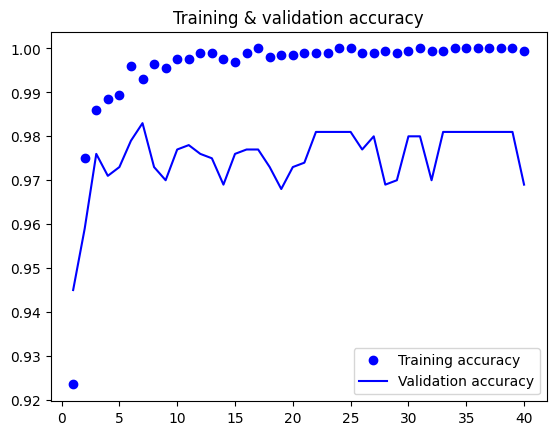

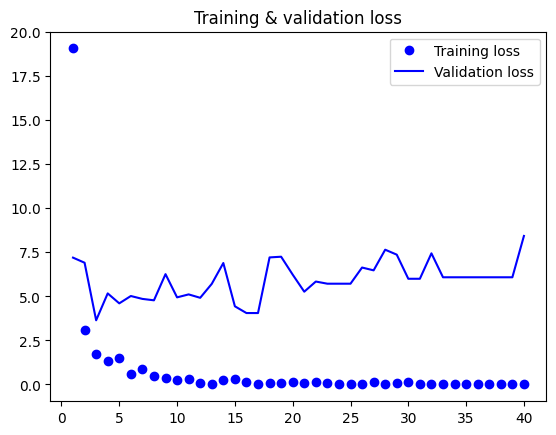

In [35]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training & validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training & validation loss")
plt.legend()
plt.show()

In [36]:
convolution_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
convolution_base.trainable = False

In [37]:
convolution_base.trainable = True
print("This is the number of trainable weights "
      "before freezing the conv base:", len(convolution_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26


In [38]:
convolution_base.trainable = False
print("This is the number of trainable weights "
      "after freezing the conv base:", len(convolution_base.trainable_weights))

This is the number of trainable weights after freezing the conv base: 0


This code provides a visualization of the model's performance during training by plotting the training and validation loss over epochs in one graph and the training and validation accuracy over epochs in another.

In [39]:
augmentation2 = keras.Sequential(
[
layers.RandomFlip("horizontal"),
layers.RandomRotation(0.1),
layers.RandomZoom(0.2),
]
)
input22 = keras.Input(shape=(180, 180, 3))
x1 = augmentation2(input22)
x1 =keras.layers.Lambda(
lambda x: keras.applications.vgg16.preprocess_input(x))(x1)
x1 = convolution_base(x1)
x1 = layers.Flatten()(x1)
x1 = layers.Dense(256)(x1)
x1 = layers.Dropout(0.5)(x1)
outputs = layers.Dense(1, activation="sigmoid")(x1)
model = keras.Model(input22, outputs)
model.compile(loss="binary_crossentropy",
optimizer="rmsprop",
metrics=["accuracy"])

Using ModelCheckpoint to save the top-performing model based on validation loss, this code trains the specified neural network model with data augmentation over 75 epochs on the training dataset.

In [40]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=75,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/75
63/63 [==============================] - 13s 184ms/step - loss: 24.1926 - accuracy: 0.8950 - val_loss: 10.3057 - val_accuracy: 0.9330
Epoch 2/75
63/63 [==============================] - 12s 189ms/step - loss: 8.0849 - accuracy: 0.9455 - val_loss: 4.3758 - val_accuracy: 0.9700
Epoch 3/75
63/63 [==============================] - 10s 148ms/step - loss: 6.8959 - accuracy: 0.9505 - val_loss: 4.0495 - val_accuracy: 0.9730
Epoch 4/75
63/63 [==============================] - 10s 153ms/step - loss: 6.6901 - accuracy: 0.9560 - val_loss: 3.1329 - val_accuracy: 0.9770
Epoch 5/75
63/63 [==============================] - 10s 150ms/step - loss: 4.7576 - accuracy: 0.9645 - val_loss: 3.0542 - val_accuracy: 0.9780
Epoch 6/75
63/63 [==============================] - 10s 145ms/step - loss: 4.5847 - accuracy: 0.9685 - val_loss: 10.0774 - val_accuracy: 0.9590
Epoch 7/75
63/63 [==============================] - 11s 174ms/step - loss: 2.9833 - accuracy: 0.9725 - val_loss: 4.0811 - val_accuracy: 0.9

In [41]:
test_model = keras.models.load_model(
 "feature_extraction_with_data_augmentation.keras",safe_mode=False)
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 94ms/step - loss: 1.7070 - accuracy: 0.9810
Test accuracy: 0.981


A pretrained VGG16 model with Fine-tuning

Fine-tuning involves training the newly added element of the model (the fully connected classifier in this case) and these top layers simultaneously, as well as unfreezing a few top layers of a frozen model foundation used for feature extraction. Because it adjusts the more abstract representations of the model that are being reused to make them more pertinent to the current task, this process is known as fine-tuning.


In [42]:
convolution_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [43]:
convolution_base.trainable = True
for layer in convolution_base.layers[:-4]:
    layer.trainable = False

Fine-tuning the model

This code trains the model for 50 epochs on the training dataset with validation, storing the best model based on validation loss. It then compiles the model using binary crossentropy loss and RMSprop optimizer with a specified learning rate.

In [44]:
model.compile(loss="binary_crossentropy",
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
63/63 [==============================] - 16s 209ms/step - loss: 0.2699 - accuracy: 0.9925 - val_loss: 1.6119 - val_accuracy: 0.9830
Epoch 2/50
63/63 [==============================] - 11s 160ms/step - loss: 0.3011 - accuracy: 0.9905 - val_loss: 1.8555 - val_accuracy: 0.9790
Epoch 3/50
63/63 [==============================] - 12s 192ms/step - loss: 0.4422 - accuracy: 0.9915 - val_loss: 1.9352 - val_accuracy: 0.9770
Epoch 4/50
63/63 [==============================] - 11s 166ms/step - loss: 0.3507 - accuracy: 0.9915 - val_loss: 1.7995 - val_accuracy: 0.9810
Epoch 5/50
63/63 [==============================] - 12s 190ms/step - loss: 0.3211 - accuracy: 0.9880 - val_loss: 1.6804 - val_accuracy: 0.9840
Epoch 6/50
63/63 [==============================] - 11s 167ms/step - loss: 0.3139 - accuracy: 0.9905 - val_loss: 3.2469 - val_accuracy: 0.9700
Epoch 7/50
63/63 [==============================] - 12s 190ms/step - loss: 0.3683 - accuracy: 0.9935 - val_loss: 1.8258 - val_accuracy: 0.9830

This code provides a visual representation of the model's performance during training by plotting the training and validation loss over epochs in one graph and the training and validation accuracy over epochs in another graph.

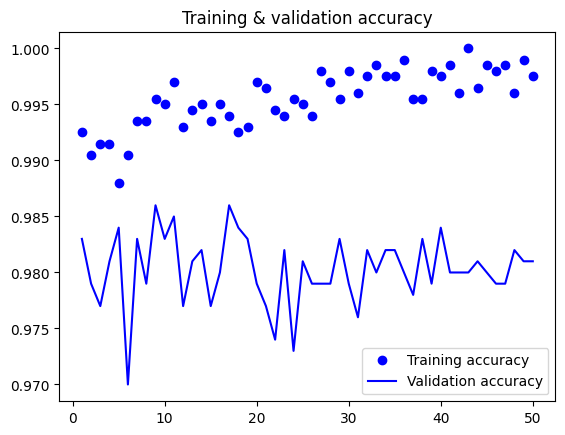

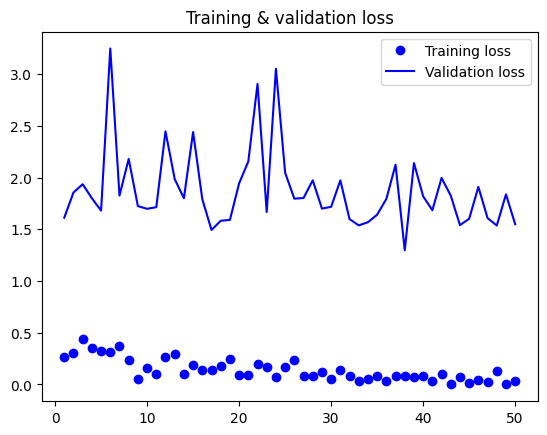

In [45]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training & validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training & validation loss")
plt.legend()
plt.show()

This code provides a visual representation of the model's performance during training by plotting the training and validation loss over epochs in one graph and the training and validation accuracy over epochs in another graph.

In [46]:
model = keras.models.load_model("fine_tuning.keras",safe_mode=False)
test_loss, test_acc = model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

32/32 [==============================] - 4s 89ms/step - loss: 2.2537 - accuracy: 0.9790
Test accuracy: 0.979
